# Optimisation topologique non-linéaire

In [1]:
# Enlever les  # pour que les figures s'ouvrent dans une fenêtre interactive à part

#%matplotlib qt5
from module_optim_topo import *
from ngsolve.solvers import Newton
from IPython.display import clear_output
from scipy.optimize import root
from copy import copy
#plt.ion()

## 1) Maillage

In [2]:
mesh = meshLamDisk(30, h = 1/30)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## 2) Définition du matériau

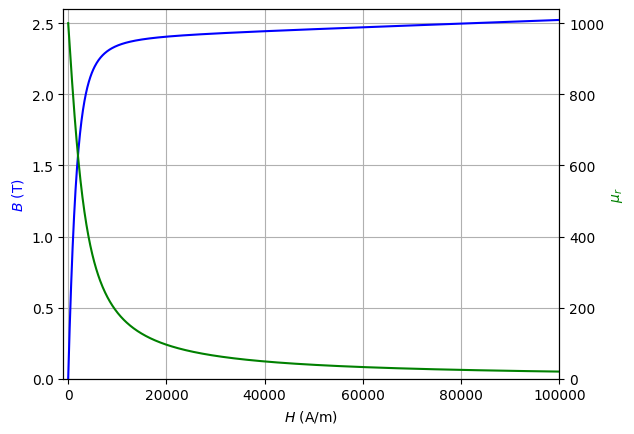

In [3]:
mu_r0 = 1000
hsat = 3e6/mu_r0
mu0 = 4e-7*np.pi

def b(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return mu0*(2*mu_r0*h-(np.arctan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )
    return mu0*(2*mu_r0*h-(atan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )

def dbdh(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return -mu0*((2*mu_r0 - 1)*(np.arctan(h/hsat)/np.pi + 1/2) - 2*mu_r0 + (h*(2*mu_r0 - 1))/(hsat*np.pi*(h**2/hsat**2 + 1)))
    return -mu0*((2*mu_r0 - 1)*(atan(h/hsat)/np.pi + 1/2) - 2*mu_r0 + (h*(2*mu_r0 - 1))/(hsat*np.pi*(h**2/hsat**2 + 1)))

def mu(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return b(h)/h*rho + (1-rho)*mu0

def dmudh(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return (dbdh(h)*h - b(h))/(h**2)*rho

def dmudrho(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return b(h)/h - mu0

# Tracé
H = np.linspace(1e-6,1e5,1000)
fig, ax1 = plt.subplots()
plt.grid()
ax2 = ax1.twinx()
ax1.plot(H,b(H), 'b-') ; ax2.plot(H,b(H)/H/mu0, 'g-')

ax1.axis([-1000,1e5,0,2.6]) ;
ax1.set_xlabel('$H$ (A/m)') ; ax1.set_ylabel('$B$ (T)', color='b')
ax2.set_ylabel('$\mu_r$', color='g') ; ax2.axis([-1000,1e5,0,1040])
plt.show()

## 3) Eléments finis non-linéaires

In [4]:
def solveDual_NL(rho, bmoy ,mesh):
    # le champ 1 est vertical, le champ 2 est horizontal
    # on impose les flux
        
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    K1 = BilinearForm(fespace_H1, symmetric=True)
    K1 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    K1 += psi*bmoy*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    K1 += -psi*bmoy*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_up|right_up"))
    
    K2 = BilinearForm(fespace_H1, symmetric=True)
    K2 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    K2 += psi*bmoy*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("right_up|right_bot"))
    K2 += - psi*bmoy*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("left_up|left_bot"))
    
    phi1 = GridFunction(fespace_H1)
    phi2 = GridFunction(fespace_H1)
    
    d = min(0.1,1/(np.exp(4*bmoy))) #réglage heuristique de l'amortissement
    
    conv1 = Newton(K1,phi1, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=500, maxerr=1e-8, dampfactor = d, inverse="pardiso")
    conv2 = Newton(K2,phi2, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=500, maxerr=1e-8, dampfactor = d, inverse="pardiso")
    
    return phi1, phi2, conv1[0], conv2[0]

## 3) Fonction objectif

In [5]:
def fObjectif(ud, uq, rho):
    return compliance(ud, mu(ud,rho), mesh) - compliance(uq, mu(uq,rho), mesh)

def fracVol(rho,mesh):
    return Integrate(rho,mesh) / Integrate(CoefficientFunction(1),mesh)

## 4) Adjoint et gradient

In [6]:
def solveAdjoint(ud, uq, rho):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    dK1 = BilinearForm(fespace_H1, symmetric=True)
    dK1 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    dK2 = BilinearForm(fespace_H1, symmetric=True)
    dK2 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    
    dK1.AssembleLinearization(ud.vec)
    dK2.AssembleLinearization(uq.vec)
    
    dJ1 = LinearForm(fespace_H1)
    
    norm_hd = sqrt(1e-15+grad(ud)*grad(ud))
    dJ1 += - (dmudh(ud,rho)*norm_hd*grad(ud)*grad(psi)/2 + mu(ud,rho)*grad(ud)*grad(psi))*dx 
    
    norm_hq = sqrt(1e-15+grad(uq)*grad(uq))
    dJ2 = LinearForm(fespace_H1)
    dJ2 += ( dmudh(uq,rho)*norm_hq*grad(uq)*grad(psi)/2 + mu(uq,rho)*grad(psi)*grad(uq) )*dx 

    dJ1.Assemble()
    dJ2.Assemble()
    
    lb1 = GridFunction(fespace_H1)
    lb2 = GridFunction(fespace_H1)
    
    lb1.vec.data = (dK1.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ1.vec)
    lb2.vec.data = (dK2.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ2.vec)

    return lb1,lb2


def grad_fObjectif(ud, uq, lbd, lbq, rho):
    mu1 = mu(ud,rho)
    mu2 = mu(uq,rho)
    Lag = (grad(lbd)*mu1*grad(ud) + grad(lbq)*mu2*grad(uq))*dx # FV
    Lag += (grad(ud)*mu1* grad(ud) -  grad(uq)*mu2* grad(uq))/2*dx # fonction objectif
    rho_test = rho.space.TestFunction()
    temp = LinearForm(rho.space)
    temp += Lag.Diff(rho,rho_test)
    temp.Assemble()
    r_temp = GridFunction(rho.space)
    r_temp.vec.data = temp.vec
    return r_temp

## 5) Optimisation

In [7]:
#listeBmoy = np.arange(0.2,2.6,0.2) # (long!)
listeBmoy = [0.2] # 

listeRho = []
listeJd = []
listeJq = []
listeJ =[]
listeRhoFrac = []
listeIter = []

for Bmoy in listeBmoy:

## Initialisation

    alpha = 1/10          # Pas initial
    alpha_min = 1e-6      # Pas minimal
    alpha_max = 1/2       # Pas maximal
    n_max = 1000          # Nombre d'itérations de l'algorithme d'optimisation
    n = 0

# Définition de la situation initiale
    spaceRho = L2(mesh)
    rho = GridFunction(spaceRho)
    rho.Set(0.5)

    ud, uq, conv1, conv2 = solveDual_NL(rho, Bmoy, mesh)
    objectiveHistory = [fObjectif(ud, uq, rho)]
    rhoHistory = [copy(rho)]
    fracVolHistory = [fracVol(rho,mesh)]

## Boucle d'optimisation


    while( n < n_max and alpha > alpha_min):
    
    # 1) Calcul de l'état physique :
        ud, uq, conv1, conv2 = solveDual_NL(rho, Bmoy, mesh)
        
        if conv1==-1 or conv2==-1:
            print('non-convergence NR') # ça peut arriver... dans ce cas, baisser le damping ou bien augmenter maxit
            break
    
    # 2) Calcul du gradient :
        lbd, lbq = solveAdjoint(ud, uq, rho)
        gradient = grad_fObjectif(ud, uq, lbd, lbq, rho)
    
    # 3) Mise à jour :
        rho_test = GridFunction(spaceRho)
    
    # 4 normalisation du gradient :
        g = GridFunction(spaceRho)
        g.Set(gradient)
        g.vec[:] = np.sign(g.vec[:].FV().NumPy())
        #g = 2*atan(gradient)/np.pi
    
    # 5 mise à jour :
        rho_test.Set(rho - alpha *g) 
        n += 1
    
    # 6) Projection :
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
    
    
    # 7) Contrôle du pas :
        ud_test, uq_test, conv1, conv2 = solveDual_NL(rho_test,Bmoy, mesh)
        
        if conv1==-1 or conv2==-1:
            print('non-convergence NR')
            break
            
        objectiveHistory.append(fObjectif(ud_test, uq_test, rho_test))
        clear_output(wait = True)
    
        print(f'Bmoy = {Bmoy} | it n°{n} | f = {objectiveHistory[-1]} | pas = {alpha} | frac. vol = {fracVolHistory[-1]}')
    
        if (objectiveHistory[-1] >= objectiveHistory[-2]):
            alpha = alpha/2
            objectiveHistory.pop();
        else:
            alpha = min([alpha*1.2,alpha_max])
            rho = rho_test
            rhoHistory.append(copy(rho))
            fracVolHistory.append(fracVol(rho,mesh))
            
    if conv1==-1 or conv2==-1:
        break
            
    listeRho.append(copy(rhoHistory[-1]))
    listeJd.append(compliance(ud, mu(ud,rho), mesh))
    listeJq.append(compliance(uq, mu(uq,rho), mesh))
    listeJ.append(objectiveHistory[-1])
    listeRhoFrac.append(fracVolHistory[-1])
    listeIter.append(n)

Bmoy = 0.2 | it n°1000 | f = -25045.30499511703 | pas = 0.00023718264284993486 | frac. vol = 0.3943475498206137


## 6) Tracés

In [8]:
Draw(rho,max=1,min=0, settings = {'mesh' : False, 'edges' : False})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

BaseWebGuiScene

In [10]:
Draw(mu(ud,rho)*grad(ud),mesh, min = 0, max=3, vectors = { "grid_size":20},
     settings={'mesh' : False, 'colormap_ncolors' : 256})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'colormap_ncol…

BaseWebGuiScene